# Puerto Rico water quality measurements-results data

Adapted from **ODM2 API: Retrieve, manipulate and visualize ODM2 water quality measurement-type data**

This example shows how to use the ODM2 Python API (`odm2api`) to connect to an ODM2 database, retrieve data, and analyze and visualize the data. The [database (iUTAHGAMUT_waterquality_measurementresults_ODM2.sqlite)](https://github.com/ODM2/ODM2PythonAPI/blob/master/Examples/data/iUTAHGAMUT_waterquality_measurementresults_ODM2.sqlite) contains ["measurement"-type results](http://vocabulary.odm2.org/resulttype/measurement/).

This example uses SQLite for the database because it doesn't require a server. However, the ODM2 Python API demonstrated here can alse be used with ODM2 databases implemented in MySQL, PostgreSQL or Microsoft SQL Server.

More details on the ODM2 Python API and its source code and latest development can be found at https://github.com/ODM2/ODM2PythonAPI

[Emilio Mayorga](https://github.com/emiliom/). Last updated 2019-3-27.

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

import odm2api
from odm2api.ODMconnection import dbconnection
import odm2api.services.readService as odm2rs

/home/mayorga/miniconda/envs/odm2client/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [2]:
pd.__version__, gpd.__version__, folium.__version__

(u'0.24.2', u'0.4.1', u'0.8.3')

**odm2api version used** to run this notebook:

In [3]:
odm2api.__version__

u'0.7.1'

## Connect to the ODM2 SQLite Database

This example uses an ODM2 SQLite database file loaded with water quality sample data from multiple monitoring sites in the [iUTAH](https://iutahepscor.org/) Gradients Along Mountain to Urban Transitions ([GAMUT](http://data.iutahepscor.org/mdf/Data/Gamut_Network/)) water quality monitoring network. Water quality samples have been collected and analyzed for nitrogen, phosphorus, total coliform, E-coli, and some water isotopes. The [database (iUTAHGAMUT_waterquality_measurementresults_ODM2.sqlite)](https://github.com/ODM2/ODM2PythonAPI/blob/master/Examples/data/iUTAHGAMUT_waterquality_measurementresults_ODM2.sqlite) contains ["measurement"-type results](http://vocabulary.odm2.org/resulttype/measurement/).

The example database is located in the `data` sub-directory.

In [4]:
# Assign directory paths and SQLite file name
dbname_sqlite = "MariaWaterQualityData.sqlite"

# sqlite_pth = os.path.join("data", dbname_sqlite)
sqlite_pth = dbname_sqlite

In [5]:
try:
    session_factory = dbconnection.createConnection('sqlite', sqlite_pth)
    read = odm2rs.ReadODM2(session_factory)
    print("Database connection successful!")
except Exception as e:
    print("Unable to establish connection to the database: ", e)

Database connection successful!


## Run Some Basic Queries on the ODM2 Database

This section shows some examples of how to use the API to run both simple and more advanced queries on the ODM2 database, as well as how to examine the query output in convenient ways thanks to Python tools.

Simple query functions like **getVariables( )** return objects similar to the entities in ODM2, and individual attributes can then be retrieved from the objects returned. 

### Get all Variables
A simple query with simple output.

In [6]:
# Get all of the Variables from the ODM2 database then read the records
# into a Pandas DataFrame to make it easy to view and manipulate
allVars = read.getVariables()

variables_df = pd.DataFrame.from_records([vars(variable) for variable in allVars], 
                                         index='VariableID')
variables_df.head(10)

,NoDataValue,SpeciationCV,VariableCode,VariableDefinition,VariableNameCV,VariableTypeCV,_sa_instance_state
VariableID,,,,,,,
1,-9999.0000000000,Not Applicable,pH,None,pH,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
2,-9999.0000000000,Not Applicable,DO,None,"Oxygen, dissolved",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
3,-9999.0000000000,Not Applicable,FirstDrawTemp,None,Temperature,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
4,-9999.0000000000,Not Applicable,Free Cl2,None,Chlorine,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
5,-9999.0000000000,Not Applicable,Total Cl2,None,Chlorine,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
6,-9999.0000000000,Not Applicable,Turbidity,None,Turbidity,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
7,-9999.0000000000,Not Applicable,InitialTemp,None,Temperature,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
8,-9999.0000000000,Not Applicable,FinalTemp,None,Temperature,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
9,-9999.0000000000,Not Applicable,Na_filt,None,"Sodium, dissolved",Water quality,<sqlalchemy.orm.state.InstanceState object at ...


### Get all People
Another simple query.

In [7]:
allPeople = read.getPeople()
pd.DataFrame.from_records([vars(person) for person in allPeople]).head()

,PersonFirstName,PersonID,PersonLastName,PersonMiddleName,_sa_instance_state
0,William,1,Rhoads,,<sqlalchemy.orm.state.InstanceState object at ...
1,Kelsey,2,Pieper,,<sqlalchemy.orm.state.InstanceState object at ...
2,Graciela,3,Ramírez Toro,,<sqlalchemy.orm.state.InstanceState object at ...
3,Jeffrey,4,Parks,,<sqlalchemy.orm.state.InstanceState object at ...


### Site Sampling Features: pass arguments to the API query

Some of the API functions accept arguments that let you subset what is returned. For example, I can query the database using the **getSamplingFeatures( )** function and pass it a SamplingFeatureType of "Site" to return a list of those SamplingFeatures that are Sites.

In [8]:
# Get all of the SamplingFeatures from the ODM2 database that are Sites
siteFeatures = read.getSamplingFeatures(sftype='Site')

# Read Sites records into a Pandas DataFrame
# "if sf.Latitude" is used only to instantiate/read Site attributes)
df = pd.DataFrame.from_records([vars(sf) for sf in siteFeatures if sf.Latitude])

Since we know this is a *geospatial* dataset (Sites, which have latitude and longitude), we can use more specialized Python tools like `GeoPandas` (geospatially enabled Pandas) and `Folium` interactive maps.

In [9]:
# Create a GeoPandas GeoDataFrame from Sites DataFrame
ptgeom = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=ptgeom, crs={'init': 'epsg:4326'})
gdf.head(5)

,ElevationDatumCV,Elevation_m,FeatureGeometryWKT,Latitude,Longitude,SamplingFeatureCode,SamplingFeatureDescription,SamplingFeatureGeotypeCV,SamplingFeatureID,SamplingFeatureName,SamplingFeatureTypeCV,SamplingFeatureUUID,SiteTypeCV,SpatialReferenceID,_sa_instance_state,geometry
0,EGM96,749.0,None,18.200178,-66.664513,SystemD1_SGW,"System D1 Surface water, as far upstream as po...",None,1,System D1 Surface Water,Site,5BE27C7B-0A37-49F9-AF8C-075F745FA23E,Water-distribution system,4,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-66.664513 18.200178)
1,EGM96,749.0,None,18.200178,-66.664513,SystemD1_Res,"System D1 Surface water, at the point it is co...",None,2,System D1 Reservoir,Site,C279AE16-3EBE-419A-9ACF-ADCCA0E22205,Water-distribution system,4,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-66.664513 18.200178)
2,EGM96,749.0,None,18.200178,-66.664513,SystemD1_HT,"System D1 Surface water, from a holding/settli...",None,3,System D1 Holding Tank,Site,1C5BD9E3-10AA-4207-A71A-190030CEDCCE,Water-distribution system,4,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-66.664513 18.200178)
3,EGM96,749.0,None,18.200178,-66.664513,SystemD1_PV,"System D1 Surface water, from a pipe vent valv...",None,4,System D1 Pipe Vent,Site,B972B4CB-FF82-44A2-BC55-E53CD0B13B1B,Water-distribution system,4,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-66.664513 18.200178)
4,EGM96,749.0,None,18.200178,-66.664513,SystemD1_ST,"System D1 Surface water, from setting tank (on...",None,5,System D1 Settling Tank,Site,33FA9DB6-D749-40A8-977F-A696F26E78A1,Water-distribution system,4,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-66.664513 18.200178)


In [10]:
# Number of records (features) in GeoDataFrame
len(gdf)

89

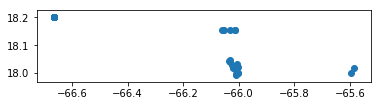

In [11]:
# A trivial but easy-to-generate GeoPandas plot
gdf.plot();

A site has a `SiteTypeCV`. Let's examine the site type distribution, and use that information to create a new GeoDataFrame column to specify a map marker color by `SiteTypeCV`.

In [12]:
gdf['SiteTypeCV'].value_counts()

Water-distribution system    67
Stream                       22
Name: SiteTypeCV, dtype: int64

**Now we'll create an interactive and helpful `Folium` map of the sites.** This map features:
- Automatic panning to the location of the sites (no hard wiring, except for the zoom scale), based on GeoPandas functionality and information from the ODM2 Site Sampling Features
- Color coding by `SiteTypeCV` 
- Marker clustering
- Simple marker pop ups with content from the ODM2 Site Sampling Features

In [13]:
gdf["color"] = gdf.apply(lambda feat: 'green' if feat['SiteTypeCV'] == 'Stream' else 'red', axis=1)

In [14]:
m = folium.Map(tiles='CartoDB positron')

marker_cluster = MarkerCluster().add_to(m)
for idx, feature in gdf.iterrows():
    folium.Marker(location=[feature.geometry.y, feature.geometry.x], 
                  icon=folium.Icon(color=feature['color']),
                  popup="{0} ({1}): {2}".format(
                      feature['SamplingFeatureCode'], feature['SiteTypeCV'], 
                      feature['SamplingFeatureName'])
                 ).add_to(marker_cluster)


# Set the map extent (bounds) to the extent of the ODM2 sites
m.fit_bounds(m.get_bounds())
    
# Done with setup. Now render the map
m

In [15]:
# Get the SamplingFeature object for a particular SamplingFeature by passing its SamplingFeatureCode
site_sf_code = 'SystemD1_PV'

sf = read.getSamplingFeatures(codes=[site_sf_code])[0]
type(sf)

odm2api.models.Sites

In [16]:
# Simple way to examine the content (properties) of a Python object, as if it were a dictionary
vars(sf)

{'ElevationDatumCV': u'EGM96',
 'Elevation_m': 749.0,
 'FeatureGeometryWKT': None,
 'Latitude': 18.200178,
 'Longitude': -66.664513,
 'SamplingFeatureCode': u'SystemD1_PV',
 'SamplingFeatureDescription': u'System D1 Surface water, from a pipe vent valve to keep water flowing (open to atmosphere)',
 'SamplingFeatureGeotypeCV': None,
 'SamplingFeatureID': 4,
 'SamplingFeatureName': u'System D1 Pipe Vent',
 'SamplingFeatureTypeCV': u'Site',
 'SamplingFeatureUUID': u'B972B4CB-FF82-44A2-BC55-E53CD0B13B1B',
 'SiteTypeCV': u'Water-distribution system',
 'SpatialReferenceID': 4,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f10459e0210>}

You can also drill down and get objects linked by foreign keys. The API returns related objects in a nested hierarchy so they can be interrogated in an object oriented way. So, if I use the **getResults( )** function to return a Result from the database (e.g., a "Measurement" Result), I also get the associated Action that created that Result (e.g., a "Specimen analysis" Action).

In [17]:
try:
    # Call getResults, but return only the first Result
    firstResult = read.getResults()[0]
    frfa = firstResult.FeatureActionObj
    frfaa = firstResult.FeatureActionObj.ActionObj
    print("The FeatureAction object for the Result is: ", frfa)
    print("The Action object for the Result is: ", frfaa)
    
    # Print some Action attributes in a more human readable form
    print("\nThe following are some of the attributes for the Action that created the Result: ")
    print("ActionTypeCV: {}".format(frfaa.ActionTypeCV))
    print("ActionDescription: {}".format(frfaa.ActionDescription))
    print("BeginDateTime: {}".format(frfaa.BeginDateTime))
    print("EndDateTime: {}".format(frfaa.EndDateTime))
    print("MethodName: {}".format(frfaa.MethodObj.MethodName))
    print("MethodDescription: {}".format(frfaa.MethodObj.MethodDescription))
except Exception as e:
    print("Unable to demo Foreign Key Example: {}".format(e))

('The FeatureAction object for the Result is: ', <FeatureActions({'FeatureActionID': 84, 'SamplingFeatureID': 90, 'ActionID': 84})>)
('The Action object for the Result is: ', <Actions({'MethodID': 11, 'ActionDescription': None, 'ActionFileLink': None, 'EndDateTime': None, 'BeginDateTime': datetime.datetime(2018, 4, 26, 0, 0), 'BeginDateTimeUTCOffset': -4, 'ActionTypeCV': u'Specimen analysis', 'ActionID': 84, 'EndDateTimeUTCOffset': None})>)

The following are some of the attributes for the Action that created the Result: 
ActionTypeCV: Specimen analysis
ActionDescription: None
BeginDateTime: 2018-04-26 00:00:00
EndDateTime: None
MethodName: Inorganics Measurements
Unable to demo Foreign Key Example: 'ascii' codec can't encode character u'\u03bc' in position 457: ordinal not in range(128)


In [18]:
vars(frfaa)

{'ActionDescription': None,
 'ActionFileLink': None,
 'ActionID': 84,
 'ActionTypeCV': u'Specimen analysis',
 'BeginDateTime': datetime.datetime(2018, 4, 26, 0, 0),
 'BeginDateTimeUTCOffset': -4,
 'EndDateTime': None,
 'EndDateTimeUTCOffset': None,
 'MethodID': 11,
 'MethodObj': <Methods({'MethodCode': u'Inorganics', 'MethodID': 11, 'MethodDescription': u'Inorganics were measured by inductively coupled plasma/mass spectrometry (ICP/MS) following Standard Method 3125B. For total inorganic concentrations, samples were aliquoitted in the field directly from 1 L HDPE bottles to 10 mL tubes and were measured after acidification with 2% nitric acid and a minimum of 24 hours holding time. For "soluble" inorganics (operationally defined as passing a 0.45 um filter), unacidified samples were passed through a 0.45\u03bcm pore size filter in the field to differentiate \u201csoluble\u201d metals from particulate and were measured after acidification with 2% nitric acid and a minimum of 24 hours ho

In [19]:
vars(frfaa.MethodObj)

{'MethodCode': u'Inorganics',
 'MethodDescription': u'Inorganics were measured by inductively coupled plasma/mass spectrometry (ICP/MS) following Standard Method 3125B. For total inorganic concentrations, samples were aliquoitted in the field directly from 1 L HDPE bottles to 10 mL tubes and were measured after acidification with 2% nitric acid and a minimum of 24 hours holding time. For "soluble" inorganics (operationally defined as passing a 0.45 um filter), unacidified samples were passed through a 0.45\u03bcm pore size filter in the field to differentiate \u201csoluble\u201d metals from particulate and were measured after acidification with 2% nitric acid and a minimum of 24 hours holding time. A nominal standard curve from 0 to 5,000 or 50,000 ppb (depending on the inorganic of interest) was run for calibration. A standard check at 0 and 100 ppb was run every 10 samples for QAQC.',
 'MethodID': 11,
 'MethodLink': None,
 'MethodName': u'Inorganics Measurements',
 'MethodTypeCV': u'

### Get a Result and its Attributes

Because all of the objects are returned in a nested form, if you retrieve a result, you can interrogate it to get all of its related attributes. When a Result object is returned, it includes objects that contain information about Variable, Units, ProcessingLevel, and the related Action that created that Result.

In [20]:
print("------- Example of Retrieving Attributes of a Result -------")
try:
    firstResult = read.getResults()[0]
    frfa = firstResult.FeatureActionObj
    print("The following are some of the attributes for the Result retrieved: ")
    print("ResultID: {}".format(firstResult.ResultID))
    print("ResultTypeCV: {}".format(firstResult.ResultTypeCV))
    print("ValueCount: {}".format(firstResult.ValueCount))
    print("ProcessingLevel: {}".format(firstResult.ProcessingLevelObj.Definition))
    print("SampledMedium: {}".format(firstResult.SampledMediumCV))
    print("Variable: {}: {}".format(firstResult.VariableObj.VariableCode, 
                                    firstResult.VariableObj.VariableNameCV))
    print("Units: {}".format(firstResult.UnitsObj.UnitsName))
    print("SamplingFeatureID: {}".format(frfa.SamplingFeatureObj.SamplingFeatureID))
    print("SamplingFeatureCode: {}".format(frfa.SamplingFeatureObj.SamplingFeatureCode))
except Exception as e:
    print("Unable to demo example of retrieving Attributes of a Result: {}".format(e))

------- Example of Retrieving Attributes of a Result -------
The following are some of the attributes for the Result retrieved: 
ResultID: 1
ResultTypeCV: Measurement
ValueCount: 1
ProcessingLevel: Quality controlled data
SampledMedium: Liquid aqueous
Variable: Na_filt: Sodium, dissolved
Units: parts per billion
SamplingFeatureID: 90
SamplingFeatureCode: D1_SGW


In [21]:
vars(firstResult)

{'FeatureActionID': 84,
 'FeatureActionObj': <FeatureActions({'ActionID': 84, 'SamplingFeatureID': 90, 'FeatureActionID': 84})>,
 'ProcessingLevelID': 2,
 'ProcessingLevelObj': <ProcessingLevels({'Definition': u'Quality controlled data', 'Explanation': u'Quality controlled data that have passed quality assurance procedures such as routine estimation of timing and sensor calibration or visual inspection and removal of obvious errors. An example is USGS published streamflow records following parsing through USGS quality control procedures.', 'ProcessingLevelCode': u'1', 'ProcessingLevelID': 2})>,
 'ResultDateTime': datetime.datetime(2018, 2, 26, 0, 0),
 'ResultDateTimeUTCOffset': None,
 'ResultID': 1,
 'ResultTypeCV': u'Measurement',
 'ResultUUID': u'1FFB7AB0-E156-4522-944F-24AFD1040F67',
 'SampledMediumCV': u'Liquid aqueous',
 'StatusCV': u'Complete',
 'TaxonomicClassifierID': None,
 'UnitsID': 5,
 'UnitsObj': <Units({'UnitsLink': None, 'UnitsName': u'parts per billion', 'UnitsTypeCV': 

In [22]:
vars(frfa)

{'ActionID': 84,
 'ActionObj': <Actions({'MethodID': 11, 'ActionDescription': None, 'ActionFileLink': None, 'EndDateTime': None, 'BeginDateTime': datetime.datetime(2018, 4, 26, 0, 0), 'BeginDateTimeUTCOffset': -4, 'ActionTypeCV': u'Specimen analysis', 'ActionID': 84, 'EndDateTimeUTCOffset': None})>,
 'FeatureActionID': 84,
 'SamplingFeatureID': 90,
 'SamplingFeatureObj': <Specimens({'SamplingFeatureDescription': None, 'SamplingFeatureGeotypeCV': None, 'SamplingFeatureName': None, 'ElevationDatumCV': u'Unknown', 'Elevation_m': None, 'SamplingFeatureUUID': u'67071B3E-28B2-4E3F-A470-CB30D6EF9121', 'SamplingFeatureTypeCV': u'Specimen', 'SamplingFeatureCode': u'D1_SGW', 'SamplingFeatureID': 90, 'FeatureGeometryWKT': None})>,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f1043353110>}

The last block of code returns a particular Measurement Result. From that I can get the SamplingFeaureID (in this case 26) for the Specimen from which the Result was generated. But, if I want to figure out which Site the Specimen was collected at, I need to query the database to get the related Site SamplingFeature.  I can use **getRelatedSamplingFeatures( )** for this.  Once I've got the SamplingFeature for the Site, I could get the rest of the SamplingFeature attributes.

### Retrieve the "Related" Site at which a Specimen was collected

In [23]:
specimen_sf_id = frfa.SamplingFeatureObj.SamplingFeatureID

In [24]:
# specimen-entity attributes only show up after first printing one out explicitly
frfa.SamplingFeatureObj.SpecimenTypeCV

u'Grab'

In [25]:
vars(frfa.SamplingFeatureObj)

{'ElevationDatumCV': u'Unknown',
 'Elevation_m': None,
 'FeatureGeometryWKT': None,
 'IsFieldSpecimen': True,
 'SamplingFeatureCode': u'D1_SGW',
 'SamplingFeatureDescription': None,
 'SamplingFeatureGeotypeCV': None,
 'SamplingFeatureID': 90,
 'SamplingFeatureName': None,
 'SamplingFeatureTypeCV': u'Specimen',
 'SamplingFeatureUUID': u'67071B3E-28B2-4E3F-A470-CB30D6EF9121',
 'SpecimenMediumCV': u'Liquid aqueous',
 'SpecimenTypeCV': u'Grab',
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f104326b9d0>}

In [26]:
# Pass the Sampling Feature ID of the specimen, and the relationship type
relatedSite = read.getRelatedSamplingFeatures(sfid=specimen_sf_id, 
                                              relationshiptype='Was Collected at')[0]

In [27]:
vars(relatedSite)

{'ElevationDatumCV': u'EGM96',
 'Elevation_m': 749.0,
 'FeatureGeometryWKT': None,
 'Latitude': 18.200178,
 'Longitude': -66.664513,
 'SamplingFeatureCode': u'SystemD1_SGW',
 'SamplingFeatureDescription': u'System D1 Surface water, as far upstream as possible',
 'SamplingFeatureGeotypeCV': None,
 'SamplingFeatureID': 1,
 'SamplingFeatureName': u'System D1 Surface Water',
 'SamplingFeatureTypeCV': u'Site',
 'SamplingFeatureUUID': u'5BE27C7B-0A37-49F9-AF8C-075F745FA23E',
 'SiteTypeCV': u'Water-distribution system',
 'SpatialReferenceID': 4,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f1045a40890>}

-----------------------------------------

## Return Results and Data Values for a Particular Site/Variable

From the list of Variables returned above and the information about the SamplingFeature I queried above, I know that VariableID = 2 for Total Phosphorus and SiteID = 1 for the Red Butte Creek site at 1300E. I can use the **getResults( )** function to get all of the Total Phosphorus results for this site by passing in the VariableID and the SiteID.

In [28]:
siteID = relatedSite.SamplingFeatureID

In [29]:
results_all_at_site = read.getResults(siteid=siteID, restype="Measurement")

In [30]:
len(results_all_at_site)

47

In [31]:
vars(results_all_at_site[0])

{'FeatureActionID': 84,
 'FeatureActionObj': <FeatureActions({'ActionID': 84, 'SamplingFeatureID': 90, 'FeatureActionID': 84})>,
 'ProcessingLevelID': 2,
 'ProcessingLevelObj': <ProcessingLevels({'Definition': u'Quality controlled data', 'Explanation': u'Quality controlled data that have passed quality assurance procedures such as routine estimation of timing and sensor calibration or visual inspection and removal of obvious errors. An example is USGS published streamflow records following parsing through USGS quality control procedures.', 'ProcessingLevelCode': u'1', 'ProcessingLevelID': 2})>,
 'ResultDateTime': datetime.datetime(2018, 2, 26, 0, 0),
 'ResultDateTimeUTCOffset': None,
 'ResultID': 1,
 'ResultTypeCV': u'Measurement',
 'ResultUUID': u'1FFB7AB0-E156-4522-944F-24AFD1040F67',
 'SampledMediumCV': u'Liquid aqueous',
 'StatusCV': u'Complete',
 'TaxonomicClassifierID': None,
 'UnitsID': 5,
 'UnitsObj': <Units({'UnitsLink': None, 'UnitsName': u'parts per billion', 'UnitsTypeCV': 

In [32]:
res_vars = []
for r in results_all_at_site:
    res_vars.append([r.ResultID, r.ResultDateTime, r.VariableID, 
                     r.VariableObj.VariableCode, r.VariableObj.VariableNameCV, r.VariableObj.VariableDefinition])

In [33]:
# print out a count of number of results for each variable, plus the date range
# Do this by ingesting into a data frame first

In [34]:
res_vars_df = pd.DataFrame(res_vars, columns=['ResultID', 'ResultDateTime', 'VariableID', 'VariableCode', 'VariableNameCV', 'VariableDefinition'])

In [35]:
res_vars_df.head()

,ResultID,ResultDateTime,VariableID,VariableCode,VariableNameCV,VariableDefinition
0,1,2018-02-26,9,Na_filt,"Sodium, dissolved",None
1,84,2018-02-26,10,Mg_filt,"Magnesium, dissolved",None
2,167,2018-02-26,11,Al_filt,"Aluminum, dissolved",None
3,250,2018-02-26,12,Si_filt,"Silicon, dissolved",None
4,333,2018-02-26,13,P_filt,"Phosphorus, dissolved",None


In [36]:
res_vars_df.VariableCode.value_counts()

pH               2
Free Cl2         2
Total Cl2        2
Fe_filt          1
Si_filt          1
Na_tot           1
Cu_filt          1
Cu_tot           1
S_tot            1
Cl_filt          1
Fe_tot           1
Mg_tot           1
Ba_filt          1
Cr_tot           1
InitialTemp      1
S_filt           1
Al_tot           1
Mn_filt          1
FirstDrawTemp    1
Al_filt          1
Turbidity        1
FinalTemp        1
Si_tot           1
Mg_filt          1
Zn_filt          1
Ba_tot           1
P_tot            1
K_tot            1
Cl_tot           1
Br_tot           1
P_filt           1
Ca_tot           1
Pb_tot           1
Br_filt          1
Cr_filt          1
Pb_filt          1
As_filt          1
Zn_tot           1
As_tot           1
Ca_filt          1
Mn_tot           1
K_filt           1
Na_filt          1
DO               1
Name: VariableCode, dtype: int64

### Retrieve the Result (Data) Values, Then Create a Quick Time Series Plot of the Data

Now I can retrieve all of the data values associated with the list of Results I just retrieved. In ODM2, water chemistry measurements are stored as "Measurement" results. Each "Measurement" Result has a single data value associated with it. So, for convenience, the **getResultValues( )** function allows you to pass in a list of ResultIDs so you can get the data values for all of them back in a Pandas data frame object, which is easier to work with. Once I've got the data in a Pandas data frame object, I can use the **plot( )** function directly on the data frame to create a quick visualization.

**10/5/2018. NOTE CURRENT ISSUE REGARDING `ValueDateTime` RETURNED BY `read.getResultValues`.** There seems to be an unexpected behavior with the data type returned for `ValueDateTime` for SQLite databases. It should be a datetime, but it's currently a string. This is [being investigated](https://github.com/ODM2/ODM2PythonAPI/issues/158). For now, we are converting to a datetime manually in cells 25 and 27 via the statement:
```python
resultValues['ValueDateTime'] = pd.to_datetime(resultValues['ValueDateTime'])
```
This problem is present in `odm2api` version 0.7.1, but was not present in Nov. 2017

In [37]:
# function that encapsulates the `VariableID`, `getResults` and `getResultValues` queries
def get_results_and_values(siteid, variablecode):
    v = variables_df[variables_df['VariableCode'] == variablecode]
    variableID = v.index[0]
    
    results = read.getResults(siteid=siteid, variableid=variableID, restype="Measurement")
    resultIDList = [x.ResultID for x in results]
    
    # Get all of the data values for the Results in the list created above
    # Call getResultValues, which returns a Pandas Data Frame with the data
    resultValues = read.getResultValues(resultids=resultIDList, lowercols=False)
    resultValues['ValueDateTime'] = pd.to_datetime(resultValues['ValueDateTime'])
    
    return resultValues, results

In [43]:
resultValues, results = get_results_and_values(siteID, 'pH')

In [44]:
resultValues.head()

,ValueID,ResultID,DataValue,ValueDateTime,ValueDateTimeUTCOffset
0,2989,2989,6.03,2018-02-26,-5
1,3476,3476,7.03,2018-02-26,-5


In [45]:
result_select = results[0]

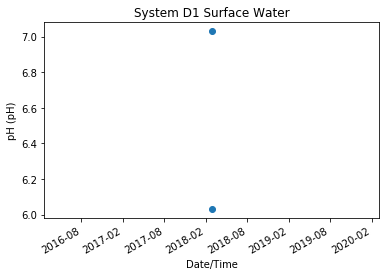

In [46]:
# Plot the time sequence of Measurement Result Values 
ax = resultValues.plot(x='ValueDateTime', y='DataValue', title=relatedSite.SamplingFeatureName,
                       kind='line', use_index=True, style='o')
ax.set_ylabel("{0} ({1})".format(result_select.VariableObj.VariableNameCV, 
                                 result_select.UnitsObj.UnitsAbbreviation))
ax.set_xlabel('Date/Time')
ax.legend().set_visible(False)

In [47]:
# results_faam = lambda results, i: results[i].FeatureActionObj.ActionObj.MethodObj
method = result_select.FeatureActionObj.ActionObj.MethodObj

print("METHOD:  {0} ({1})".format(method.MethodName, method.MethodDescription))

METHOD:  Stagnant pH (Measured using Orion 100-Series pH meter calibrated before each use in pH 4,7. and 10 buffers with automatic temperature control.)
